# [NAPARI](https://napari.org/) testing
## and adding [cellpose](https://cellpose-napari.readthedocs.io/en/latest/index.html) (installer [here](https://pypi.org/project/cellpose-napari/0.1.3/))

To upgrade run in a cell:
```python
!pip install cellpose-napari==0.1.3
!pip install cellpose --upgrade
```

```bash
napari -w cellpose-napari
```

### Basic usage:
```python
viewer = napari.view_image(data.astronaut(), rgb=True)
nbscreenshot(viewer)
viewer.close()
```

example notebooks [here](https://github.com/sofroniewn/napari-training-course/blob/master/lessons/)

In [ ]:
## to install
# !pip install napari[all]
# !pip install QT
# !pip install napari[pyqt5]
# !pip install cellpose-napari==0.1.4
# !pip install napari-nikon-nd2
# !pip install magicgui
# !pip install napari-pyclesperanto-assistant
# !pip install napari-animated-gif-io
# !pip install napari-clusters-plotter #hdbscan failed
# !pip install napari-plot-profile
# !pip install napari-brightness-contrast
# !pip install napari-curtain
# !pip install napari-3d-ortho-viewer
# !pip install napari-manual-split-and-merge-labels
# !pip install napari-crop
# !pip install napari-stl-exporter

## to upgrade:
# !pip install cellpose-napari==0.1.4
# !pip install cellpose-napari --upgrade
# !pip install cellpose --upgrade
# !pip install napari --upgrade


In [1]:
import napari
from magicgui import magicgui
from enum import Enum
import cellpose_napari
import cellpose
from cellpose import models
from napari.utils import nbscreenshot
from tifffile import imread
import numpy as np
from scipy import ndimage
from scipy.stats import mannwhitneyu, kruskal
import scikit_posthocs
import napari_nikon_nd2
import os 
from magicgui import magicgui
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import importlib
import svgutils
from svgutils.compose import *
import time
import sys
import ipywidgets
from plotParams import *
from juanNapariFx import *


pBGMenu = ipywidgets.Dropdown(options=['Light', 'Dark'],value='Light',disabled=False, layout=ipywidgets.Layout(width='20%', height='40px'))
pBGLabel = ipywidgets.widgets.Label('Select plotting style', layout=ipywidgets.Layout(width='20%', height='30px'))
pBG = ipywidgets.widgets.VBox([pBGLabel,pBGMenu])
pBG

In [2]:
applyPlotStyle(pBGMenu.value)
viewer = napari.Viewer()

Plotting style is Light
Assistant skips harvesting pyclesperanto as it's not installed.


/Users/angueyraaristjm/opt/anaconda3/lib/python3.9/site-packages/napari_tools_menu/__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


***
# Index <a id='Index'>∮</a>
***
- [Test segmentation (initial](#testSeg)
- [Extraction of z planes for analysis](#zExtract)
- [Segmentation with cellpose](#cellSeg)
- [Manual correction of segmentation](#manualCuration)
- [Create thumbnails _WIP_](#thumbnails)
- [Quantification](#quantification)

***
## Testing segmentation<a id='testSeg'>∮</a>
***
[Back to Index](#Index)

In [ ]:
# clear viewer
viewer.layers.select_all()
viewer.layers.remove_selected()

In [ ]:
dPath = "/Users/angueyraaristjm/Documents/LiImaging/A1R/zf_partial/20201009_CRtbx2a/"
fPathL = "20201009_i06b_L"
fPathM = "20201009_i06b_M"
# load the image data and inspect its shape
zfL = imread(dPath+fPathL + ".tiff")
zfM = imread(dPath+fPathM + ".tiff")
viewer.add_image(zfL, colormap='magenta')#, contrast_limits=[196,5860]);
viewer.add_image(zfM, colormap='green', blending='additive')#, contrast_limits=[223,6721]);
viewer.open(dPath+fPathL + "_seg.tiff", name='zfL_seg', plugin='builtins');
viewer.open(dPath+fPathM + "_seg.tiff", name='zfM_seg', plugin='builtins');
# nbscreenshot(viewer)

In [ ]:
nL = len(np.unique(viewer.layers['zfL_seg'].data))-1
print("Image has {0} L cones".format(nL))
nM = len(np.unique(viewer.layers['zfM_seg'].data))-1
print("Image has {0} M cones".format(nM))

dL = viewer.layers['zfL_seg'].data
dM = viewer.layers['zfM_seg'].data

Not sure how to normalize across images...
1. average GFP instensity inside M-cones? &rarr; difficult in CRISPants
1. max GFP intensity? &rarr; could be ok

In [ ]:
# eroding segmentation because it too generous with ROIs and I want to exclude GFP diffraction
viewer.layers['zfL_seg'].data = ndimage.grey_erosion(dL, size=(8,8))
viewer.layers['zfM_seg'].data = ndimage.grey_erosion(dM, size=(8,8))

L_avgG = np.zeros([nL,1])
L_avgR = np.zeros([nL,1])
# calculate mean GFP intensity inside each L cone (normalized and baseline subtracted)
maxM = viewer.layers['zfM'].data[viewer.layers['zfL_seg'].data == 0].max()
maxL = viewer.layers['zfL'].data[viewer.layers['zfL_seg'].data == 1].max()
minM = viewer.layers['zfM'].data[viewer.layers['zfL_seg'].data == 0].min()
minL = viewer.layers['zfL'].data[viewer.layers['zfL_seg'].data == 0].min()
for roi in range(nL):
    tempROI = viewer.layers['zfL_seg'].data == roi
    L_avgG[roi] = (viewer.layers['zfM'].data[tempROI].mean()-minM)/(maxM-minM)
    L_avgR[roi] = (viewer.layers['zfL'].data[tempROI].mean()-minL)/(maxL-minL)

M_avgG = np.zeros([nM,1])
M_avgR = np.zeros([nM,1])
# calculate mean GFP intensity inside each M cone (normalized and baseline subtracted)
for roi in range(nM):
    tempROI = viewer.layers['zfM_seg'].data == roi
    M_avgG[roi] = (viewer.layers['zfM'].data[tempROI].mean()-minM)/(maxM-minM)
    M_avgR[roi] = (viewer.layers['zfL'].data[tempROI].mean()-minL)/(maxL-minL)

    
nbins = 20
denseFlag = True
    
plt.figure(figsize=(8,6))
plt.hist(L_avgG, bins=np.divide(range(0,nbins+1),nbins), density = denseFlag, color = (1.0,0.5,0.0,0.5), label="L_GFP")
plt.hist(L_avgR, bins=np.divide(range(0,nbins+1),nbins), density = denseFlag, color = (1.0,0.0,0.0,0.5), label="L_tdT")

plt.hist(M_avgG, bins=np.divide(range(0,nbins+1),nbins), density = denseFlag, color = (0.0,1.0,0.0,0.5), label="M_GFP")
plt.hist(M_avgR, bins=np.divide(range(0,nbins+1),nbins), density = denseFlag, color = (0.5,1.0,0.0,0.5), label="M_tdT")

plt.xlabel("Normalized intensity", size=14)
plt.ylabel("Probability", size=14)
plt.title("")
plt.legend(loc='upper right')
# plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

In [ ]:
# viewer.layers['zfM_seg'].data = dM
viewer.layers['zfL_seg'].data = ndimage.grey_erosion(viewer.layers['zfL_seg'].data, size=(10,10))

In [ ]:
@viewer.bind_key('k')
def toggle_sel(viewer):
    if (viewer.layers['zfM_seg'].show_selected_label == True):
        viewer.layers['zfM_seg'].show_selected_label = False
    elif (viewer.layers['zfM_seg'].show_selected_label == False):
        viewer.layers['zfM_seg'].show_selected_label = True

In [ ]:
viewer.layers['zfM_seg'].show_selected_label=False

In [ ]:
viewer.layers['zfM_seg'].data

In [ ]:
viewer = napari.Viewer()

In [ ]:
# viewer.close()

***
## Extract layers from z-stacks<a id='zExtract'>∮</a>
***
[Back to Index](#Index)

In [ ]:
# get file names
dPath = "/Volumes/angueyra04/LiImaging/20221026_tbx2F0s_m2Gs2C/"
gene = 'wt'
fList = !ls $dPath/*$gene*[002,003].nd2
# fList = !ls $dPath/*$gene*['b','d'].nd2
fList = list(map(lambda st: str.replace(st, dPath + '/', 'fPath = \"'), fList))
fList = list(map(lambda st: str.replace(st, '.nd2', '\"; gene = \'' + gene + '\'; '), fList))
print(*fList, sep = "\n")

In [ ]:
# clear viewer
viewer.layers.select_all()
viewer.layers.remove_selected()

In [ ]:
# clear viewer
viewer.layers.select_all()
viewer.layers.remove_selected()

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/m2Gt2T/"

# open file
dPath = "/Volumes/angueyra04/LiImaging/20221026_tbx2F0s_m2Gs2C/"

fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_wt_L13_002"; gene = 'wt'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_wt_L13_003"; gene = 'wt'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_wt_L14_002"; gene = 'wt'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_wt_L14_003"; gene = 'wt'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_wt_L15_002"; gene = 'wt'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_wt_L15_003"; gene = 'wt'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_wt_L16_002"; gene = 'wt'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_wt_L17_002"; gene = 'wt'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_wt_L18_002"; gene = 'wt'; 

# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2bF0_L13_002"; gene = 'tbx2b'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2bF0_L13_003"; gene = 'tbx2b'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2bF0_L14_002"; gene = 'tbx2b'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2bF0_L14_003"; gene = 'tbx2b'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2bF0_L15_002"; gene = 'tbx2b'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2bF0_L15_003"; gene = 'tbx2b'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2bF0_L16_002"; gene = 'tbx2b'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2bF0_L16_003"; gene = 'tbx2b'; 

# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L09_002"; gene = 'tbx2a'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L10_002"; gene = 'tbx2a'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L10_003"; gene = 'tbx2a'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L11_002"; gene = 'tbx2a'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L11_003"; gene = 'tbx2a'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L12_002"; gene = 'tbx2a'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L12_003"; gene = 'tbx2a'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L13_002"; gene = 'tbx2a'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L13_003"; gene = 'tbx2a'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L14_002"; gene = 'tbx2a'; 
# fPath = "20221021_5dpf_m2G_s2C_1D4mCy5_tbx2aF0_L14_003"; gene = 'tbx2a'; 

# uninjected
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201009_CRtbx2a/"
# ### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09b"; zlims = [39,43]; gene = 'wt';
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09d"; zlims = [31,34]; gene = 'wt';
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10b"; zlims = [33,36]; gene = 'wt';
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10d"; zlims = [38,41]; gene = 'wt';
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11b"; zlims = [25,27]; gene = 'wt'; # this one could be example
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11d"; zlims = [31,34]; gene = 'wt';
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12b"; zlims = [23,25]; gene = 'wt';
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12d"; zlims = [31,34]; gene = 'wt';

# tbx2a
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201009_CRtbx2a/"
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a';
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b"; zlims = [00,00]; gene = 'tbx2a'; #very curved stack. would require oblique cut
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d"; zlims = [30,33]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b"; zlims = [30,33]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d"; zlims = [29,32]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b"; zlims = [36,38]; gene = 'tbx2a'; # this could be example
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d"; zlims = [45,47]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b"; zlims = [20,23]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d"; zlims = [28,30]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b"; zlims = [23,25]; gene = 'tbx2a';
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d"; zlims = [36,38]; gene = 'tbx2a'; # this in lens up

# #tbx2b
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201030_CRtbx2ab/"
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b"; zlims = [24,26]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d"; zlims = [37,39]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b"; zlims = [20,24]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d"; zlims = [27,29]; gene = 'tbx2b';

# uninjected
# dPath = "/Volumes/angueyraNEI/LiImaging/A1R/zf2021onwards/20210716_tbx2F0s/"
### 20210716: imaged 5dpf larvae to increase n specifically for tbx2b
# fPath = "20210716_5dpf_m2G_t2T_uninj_L101b"; zlims = [00,00]; zlims2 = [9,31]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L101d"; zlims = [00,00]; zlims2 = [17,27]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L102b"; zlims = [00,00]; zlims2 = [19,31]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L103b"; zlims = [00,00]; zlims2 = [16,22]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L103d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L104b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L104d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L105b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L105d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L106b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L106d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip

# # tbx2a
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L101b"; zlims = [25,27]; zlims2 = [11,17]; gene = 'tbx2a'; # might be difficult to segment
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L101d"; zlims = [30,32]; zlims2 = [18,20]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L102b"; zlims = [38,41]; zlims2 = [28,33]; gene = 'tbx2a'; # lots of M cones south?
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L102d"; zlims = [38,42]; zlims2 = [21,31]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L103b"; zlims = [38,40]; zlims2 = [26,29]; gene = 'tbx2a'; # this one has to be wt
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L103d"; zlims = [27,29]; zlims2 = [11,13]; gene = 'tbx2a'; # this one has to be wt
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L104b"; zlims = [23,25]; zlims2 = [11,14]; gene = 'tbx2a';
### fPath = "20210716_5dpf_m2G_t2T_tbx2a_L105b"; zlims = [21,23]; zlims2 = [14,19]; gene = 'tbx2a'; # huge rip. exclude from analysis
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L105d"; zlims = [31,33]; zlims2 = [22,27]; gene = 'tbx2a'; # this one has to be wt
### fPath = "20210716_5dpf_m2G_t2T_tbx2a_L106b"; zlims = [27,38]; zlims2 = [15,30]; gene = 'tbx2a'; # too curved, makes cells overlap in mip. exclude from analysis
### fPath = "20210716_5dpf_m2G_t2T_tbx2a_L106d"; zlims = [24,29]; zlims2 = [6,26]; gene = 'tbx2a'; # alwo too curved, makes cells overlap in mip. exclude from analysis

# # tbx2b
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L101b"; gene = 'tbx2b'; zlims = [27,30]; zlims2 = [13,16];
# ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L101d"; gene = 'tbx2b'; zlims = [29,32]; zlims2 = [11,21]; # somewhat curved. Exclude
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L102b"; gene = 'tbx2b'; zlims = [23,27]; zlims2 = [11,16]; # this could be example
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L102d"; gene = 'tbx2b'; zlims = [24,27]; zlims2 = [8,13]; # good too
# ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L103b"; gene = 'tbx2b'; # not GFP+; exclude
# ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L103d"; gene = 'tbx2b'; # not GFP+; exclude
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L104b"; gene = 'tbx2b'; zlims = [25,27]; zlims2 = [8,13];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L104d"; gene = 'tbx2b'; zlims = [29,32]; zlims2 = [11,22];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L105b"; gene = 'tbx2b'; zlims = [26,28]; zlims2 = [9,15];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L105d"; gene = 'tbx2b'; zlims = [21,24]; zlims2 = [8,13];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L106b"; gene = 'tbx2b'; zlims = [34,37]; zlims2 = [15,22];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L106d"; gene = 'tbx2b'; zlims = [35,38]; zlims2 = [23,27];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L107b"; gene = 'tbx2b'; zlims = [26,30]; zlims2 = [13,17];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L107d"; gene = 'tbx2b'; zlims = [29,32]; zlims2 = [14,17];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L108b"; gene = 'tbx2b'; zlims = [31,34]; zlims2 = [16,21];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L108d"; gene = 'tbx2b'; zlims = [31,34]; zlims2 = [19,22]; # really flat. could be example
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L109b"; gene = 'tbx2b'; zlims = [32,34]; zlims2 = [17,21];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L110b"; gene = 'tbx2b'; zlims = [24,26]; zlims2 = [8,14];
# ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L110d"; gene = 'tbx2b'; # side-view; really good one
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L111b"; gene = 'tbx2b'; zlims = [30,33]; zlims2 = [15,17]; # really flat. could be example
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L112b"; gene = 'tbx2b'; zlims = [28,30]; zlims2 = [14,18]; # mutant? confirm genotype



# create subdirectory for analysis
dOut = dAnalysis + gene + '/' + fPath + '/'
if (os.path.isdir(dOut)==False):
    os.mkdir(dOut)

print('Viewer cleared...')

# clear key binds
@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
    ...
@viewer.bind_key('b', overwrite=True)
def toggle_sel(viewer):
    ...
@viewer.bind_key('Shift-x', overwrite=True)
def removeLabel(viewer):
    ...

# load whole stack to help with nuclei
print('Loading files...')
viewer.open((dPath+fPath + ".nd2"))
viewer.layers.remove(viewer.layers[len(viewer.layers)-1]) # remove transmitted detector image
viewer.layers.select_next();

if len(viewer.layers)==2: # GFP and RFP channel
    nChannels = 2
    viewer.layers[0].colormap = 'green'
    viewer.layers[0].name = 'M'
    viewer.layers[1].colormap = 'magenta'
    viewer.layers[1].name = 'L'
elif len(viewer.layers)==3: #DAPI
    nChannels = 3
    viewer.layers[0].colormap = 'gray'
    viewer.layers[0].name = 'N'
    viewer.layers[0].opacity = 1
    viewer.layers[1].colormap = 'green'
    viewer.layers[1].name = 'M'
    viewer.layers[2].colormap = 'magenta'
    viewer.layers[2].name = 'L'
elif len(viewer.layers)==4: #DAPI
    nChannels = 3
    viewer.layers[0].colormap = 'gray'
    viewer.layers[0].name = 'N'
    viewer.layers[0].opacity = 1
    viewer.layers[1].colormap = 'green'
    viewer.layers[1].name = 'M'
    viewer.layers[2].colormap = 'magenta'
    viewer.layers[2].name = 'L'
    viewer.layers[3].colormap = 'bop orange'
    viewer.layers[3].name = 'LWS'


print('Loaded: ' + fPath)

In [ ]:
# make mips (and remove any previous ones)
# for FPs ------- # for OSs # code for eyes with 1D4 immuno
zlims = [28,30]; zlims2 = [14,18];
if len(viewer.layers)>3:
    for l in viewer.layers[3:]:
        viewer.layers.remove(l)

for l in [viewer.layers[0],viewer.layers[1]]:
    l.visible = False
#     viewer.layers.remove(l.name + '_mip')
    viewer.add_image(l.data[zlims[0]:zlims[1]].max(axis=0), blending='additive', colormap = l.colormap, name = l.name + "_mip")
    
for l in [viewer.layers[2]]:
    l.visible = False
#     viewer.layers.remove(l.name + '_mip')
    viewer.add_image(l.data[zlims2[0]:zlims2[1]].max(axis=0), blending='additive', colormap = l.colormap, name = l.name + "_mip")

# # code for eyes without immuno
# # zlims = [45,47];
# if len(viewer.layers)>2:
#     for l in viewer.layers[2:]:
#         viewer.layers.remove(l)

# for l in [viewer.layers[0],viewer.layers[1]]:
#     l.visible = False
# #     viewer.layers.remove(l.name + '_mip')
#     viewer.add_image(l.data[zlims[0]:zlims[1]].max(axis=0), blending='additive', colormap = l.colormap, name = l.name + "_mip")

In [ ]:
# when things look good, save in folder for batch cellpose analysis
l = viewer.layers['M_mip']; l.save(dOut + l.name + '.tiff')
l = viewer.layers['L_mip']; l.save(dOut + l.name + '.tiff')
l = viewer.layers['LWS_mip']; l.save(dOut + l.name + '.tiff')

### Now go back to next file [&uarr;](#zExtract)

***
## Segmentation using cellpose<a id='cellSeg'>∮</a>
***
[Back to Index](#Index)

In [ ]:
# clear viewer
viewer.layers.select_all()
viewer.layers.remove_selected()

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRtbx2F0s/m2Gt2T/"

# open file

# uninjected
dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201009_CRtbx2a/"
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09b"; zlims = [39,43]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09d"; zlims = [31,34]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10b"; zlims = [33,36]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10d"; zlims = [38,41]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11b"; zlims = [25,27]; gene = 'wt'; # this one could be example
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11d"; zlims = [31,34]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12b"; zlims = [23,25]; gene = 'wt';
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12d"; zlims = [31,34]; gene = 'wt'; 

# tbx2a
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201009_CRtbx2a/"
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a';
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b"; zlims = [00,00]; gene = 'tbx2a'; #very curved stack. would require oblique cut
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d"; zlims = [30,33]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b"; zlims = [30,33]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d"; zlims = [29,32]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b"; zlims = [45,47]; gene = 'tbx2a'; # this could be example
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d"; zlims = [26,31]; gene = 'tbx2a'; 
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b"; zlims = [20,23]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d"; zlims = [28,30]; gene = 'tbx2a';
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b"; zlims = [23,25]; gene = 'tbx2a';
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d"; zlims = [36,38]; gene = 'tbx2a'; # this in lens up

# # tbx2b
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201030_CRtbx2ab/"
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b"; zlims = [24,26]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d"; zlims = [37,39]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b"; zlims = [20,24]; gene = 'tbx2b';
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d"; zlims = [27,29]; gene = 'tbx2b';

# uninjected
dPath = "/Volumes/angueyraNEI/LiImaging/A1R/zf2021onwards/20210716_tbx2F0s/"
### 20210716: imaged 5dpf larvae to increase n specifically for tbx2b
# fPath = "20210716_5dpf_m2G_t2T_uninj_L101b"; zlims = [00,00]; zlims2 = [9,31]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L101d"; zlims = [00,00]; zlims2 = [17,27]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L102b"; zlims = [00,00]; zlims2 = [19,31]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L103b"; zlims = [00,00]; zlims2 = [16,22]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L103d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L104b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L104d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L105b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L105d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L106b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L106d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip

# # tbx2a
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L101b"; zlims = [25,27]; zlims2 = [11,17]; gene = 'tbx2a'; # might be difficult to segment
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L101d"; zlims = [30,32]; zlims2 = [18,20]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L102b"; zlims = [38,41]; zlims2 = [28,33]; gene = 'tbx2a'; # lots of M cones south?
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L102d"; zlims = [38,42]; zlims2 = [21,31]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L103b"; zlims = [38,40]; zlims2 = [26,29]; gene = 'tbx2a'; # this one has to be wt
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L103d"; zlims = [27,29]; zlims2 = [11,13]; gene = 'tbx2a'; # this one has to be wt
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L104b"; zlims = [23,25]; zlims2 = [11,14]; gene = 'tbx2a';
# ### fPath = "20210716_5dpf_m2G_t2T_tbx2a_L105b"; zlims = [21,23]; zlims2 = [14,19]; gene = 'tbx2a'; # huge rip. exclude from analysis
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L105d"; zlims = [31,33]; zlims2 = [22,27]; gene = 'tbx2a'; # this one has to be wt
# ### fPath = "20210716_5dpf_m2G_t2T_tbx2a_L106b"; zlims = [27,38]; zlims2 = [15,30]; gene = 'tbx2a'; # too curved, makes cells overlap in mip. exclude from analysis
# ### fPath = "20210716_5dpf_m2G_t2T_tbx2a_L106d"; zlims = [24,29]; zlims2 = [6,26]; gene = 'tbx2a'; # alwo too curved, makes cells overlap in mip. exclude from analysis

# # tbx2b
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L101b"; gene = 'tbx2b'; zlims = [27,30]; zlims2 = [13,16];
# # ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L101d"; gene = 'tbx2b'; zlims = [29,32]; zlims2 = [11,21]; # somewhat curved. Exclude
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L102b"; gene = 'tbx2b'; zlims = [23,27]; zlims2 = [11,16]; # this could be example
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L102d"; gene = 'tbx2b'; zlims = [24,27]; zlims2 = [8,13]; # good too
# # ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L103b"; gene = 'tbx2b'; # not GFP+; exclude
# # ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L103d"; gene = 'tbx2b'; # not GFP+; exclude
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L104b"; gene = 'tbx2b'; zlims = [25,27]; zlims2 = [8,13];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L104d"; gene = 'tbx2b'; zlims = [29,32]; zlims2 = [11,22];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L105b"; gene = 'tbx2b'; zlims = [26,28]; zlims2 = [9,15];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L105d"; gene = 'tbx2b'; zlims = [21,24]; zlims2 = [8,13];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L106b"; gene = 'tbx2b'; zlims = [34,37]; zlims2 = [15,22];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L106d"; gene = 'tbx2b'; zlims = [35,38]; zlims2 = [23,27];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L107b"; gene = 'tbx2b'; zlims = [26,30]; zlims2 = [13,17];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L107d"; gene = 'tbx2b'; zlims = [29,32]; zlims2 = [14,17];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L108b"; gene = 'tbx2b'; zlims = [31,34]; zlims2 = [16,21];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L108d"; gene = 'tbx2b'; zlims = [31,34]; zlims2 = [19,22]; # really flat. could be example
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L109b"; gene = 'tbx2b'; zlims = [32,34]; zlims2 = [17,21];
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L110b"; gene = 'tbx2b'; zlims = [24,26]; zlims2 = [8,14];
# # ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L110d"; gene = 'tbx2b'; # side-view; really good one
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L111b"; gene = 'tbx2b'; zlims = [30,33]; zlims2 = [15,17]; # really flat. could be example
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L112b"; gene = 'tbx2b'; zlims = [28,30]; zlims2 = [14,18]; # mutant? confirm genotype


# create subdirectory for analysis
dOut = dAnalysis + gene + '/' + fPath + '/'
print('Viewer cleared...')

In [ ]:
viewer.layers.select_all()
viewer.layers.remove_selected()

# load mips
viewer.open(dOut + 'M' + "_mip.tiff", plugin='builtins', colormap = 'green');
viewer.open(dOut + 'L' + "_mip.tiff", plugin='builtins', colormap = 'magenta', blending='additive');
print('Loaded! Now run cellpose!!!!')

In [ ]:
# after running cellpose, rename cellpose images and save before manual curation:
baseName = 'M'
lname = baseName + '_mip'
viewer.layers[lname + '_cp_masks_000'].name = baseName + '_seg'
viewer.layers[lname + '_cp_outlines_000'].name = baseName + '_outlines'
viewer.layers[lname + '_cp_cellprob_000'].name = baseName + '_prob'
viewer.layers[lname + '_cp_flows_000'].name = baseName + '_flows'

l = viewer.layers[baseName + '_seg']; l.save(dOut + l.name + '.tiff')
l = viewer.layers[baseName + '_outlines']; l.save(dOut + l.name + '.tiff')
l = viewer.layers[baseName + '_prob']; l.save(dOut + l.name + '.tiff')
l = viewer.layers[baseName + '_flows']; l.save(dOut + l.name + '.tiff')

In [ ]:
# after running cellpose, rename cellpose images and save before manual curation:
baseName = 'L'
lname = baseName + '_mip'
viewer.layers[lname + '_cp_masks_000'].name = baseName + '_seg'
viewer.layers[lname + '_cp_outlines_000'].name = baseName + '_outlines'
viewer.layers[lname + '_cp_cellprob_000'].name = baseName + '_prob'
viewer.layers[lname + '_cp_flows_000'].name = baseName + '_flows'

l = viewer.layers[baseName + '_seg']; l.save(dOut + l.name + '.tiff')
l = viewer.layers[baseName + '_outlines']; l.save(dOut + l.name + '.tiff')
l = viewer.layers[baseName + '_prob']; l.save(dOut + l.name + '.tiff')
l = viewer.layers[baseName + '_flows']; l.save(dOut + l.name + '.tiff')

### Go back and run next one &uarr;

***
## Manual correction of cellpose segmentation<a id='manualCuration'>∮</a>
***
[Back to Index](#Index)

In [ ]:
# clear viewer
viewer.layers.select_all()
viewer.layers.remove_selected()
# for l in viewer.layers:
#         viewer.layers.remove(l)

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/m2Gt2T/"

# open file

# uninjected
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09b"; zlims = [39,43]; gene = 'wt'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i09d"; zlims = [31,34]; gene = 'wt'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10b"; zlims = [33,36]; gene = 'wt'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i10d"; zlims = [38,41]; gene = 'wt'; # done (L labels are a little generous)
fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11b"; zlims = [25,27]; gene = 'wt'; # done # this one could be example
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i11d"; zlims = [31,34]; gene = 'wt'; # done (M and L seg are quite good; example too)
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12b"; zlims = [23,25]; gene = 'wt'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_wt_i12d"; zlims = [31,34]; gene = 'wt'; # done

# # tbx2a
# Extremely difficult to segment M in F0-larvae
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b"; zlims = [36,38]; gene = 'tbx2a'; # is this supposed to be d????
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b"; zlims = [00,00]; gene = 'tbx2a'; #very curved stack. would require oblique cut
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d"; zlims = [30,33]; gene = 'tbx2a'; # done
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b"; zlims = [30,33]; gene = 'tbx2a'; # done (not bad for example if needed)
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d"; zlims = [29,32]; gene = 'tbx2a'; # done (finished M cone segmentation too)
fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b"; zlims = [45,47]; gene = 'tbx2a'; # done; EXAMPLE
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d"; zlims = [26,31]; gene = 'tbx2a'; # done (finished M cone segmentation too)
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b"; zlims = [20,23]; gene = 'tbx2a'; # done; very clean L-cone seg (not bad for example if needed)
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d"; zlims = [28,30]; gene = 'tbx2a'; # done (finished M cone segmentation too)
# fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b"; zlims = [23,25]; gene = 'tbx2a'; # done
# #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d"; zlims = [36,38]; gene = 'tbx2a'; # this in lens up

# # tbx2b
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b"; zlims = [24,26]; gene = 'tbx2b'; # done
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d"; zlims = [37,39]; gene = 'tbx2b'; # done (finished M-seg too)
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b"; zlims = [20,24]; gene = 'tbx2b'; # done
# fPath = "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d"; zlims = [27,29]; gene = 'tbx2b';

# uninjected
dPath = "/Volumes/angueyraNEI/eelImaging/A1R/zf2021onwards/20210716_tbx2F0s/"
### 20210716: imaged 5dpf larvae to increase n specifically for tbx2b
# fPath = "20210716_5dpf_m2G_t2T_uninj_L101b"; zlims = [00,00]; zlims2 = [9,31]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L101d"; zlims = [00,00]; zlims2 = [17,27]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L102b"; zlims = [00,00]; zlims2 = [19,31]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L103b"; zlims = [00,00]; zlims2 = [16,22]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L103d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L104b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L104d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L105b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; # EXAMPLE segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L105d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L106b"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip
# fPath = "20210716_5dpf_m2G_t2T_uninj_L106d"; zlims = [00,00]; zlims2 = [00,00]; gene = 'wt'; #segmented by Laura already, missing 1D4 mip

# # tbx2a
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L101b"; zlims = [25,27]; zlims2 = [11,17]; gene = 'tbx2a'; # might be difficult to segment
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L101d"; zlims = [30,32]; zlims2 = [18,20]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L102b"; zlims = [38,41]; zlims2 = [28,33]; gene = 'tbx2a'; # lots of M cones south?
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L102d"; zlims = [38,42]; zlims2 = [21,31]; gene = 'tbx2a';
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L103b"; zlims = [38,40]; zlims2 = [26,29]; gene = 'tbx2a'; # this one has to be wt
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L103d"; zlims = [27,29]; zlims2 = [11,13]; gene = 'tbx2a'; # this one has to be wt
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L104b"; zlims = [23,25]; zlims2 = [11,14]; gene = 'tbx2a';
# ### fPath = "20210716_5dpf_m2G_t2T_tbx2a_L105b"; zlims = [21,23]; zlims2 = [14,19]; gene = 'tbx2a'; # huge rip. exclude from analysis
# fPath = "20210716_5dpf_m2G_t2T_tbx2a_L105d"; zlims = [31,33]; zlims2 = [22,27]; gene = 'tbx2a'; # this one has to be wt
# ### fPath = "20210716_5dpf_m2G_t2T_tbx2a_L106b"; zlims = [27,38]; zlims2 = [15,30]; gene = 'tbx2a'; # too curved, makes cells overlap in mip. exclude from analysis
# ### fPath = "20210716_5dpf_m2G_t2T_tbx2a_L106d"; zlims = [24,29]; zlims2 = [6,26]; gene = 'tbx2a'; # alwo too curved, makes cells overlap in mip. exclude from analysis

# # tbx2b
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L101b"; gene = 'tbx2b'; zlims = [27,30]; zlims2 = [13,16]; #this one is messy and seems to have a lot of cones?
# # ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L101d"; gene = 'tbx2b'; zlims = [29,32]; zlims2 = [11,21]; # somewhat curved. Exclude
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L102b"; gene = 'tbx2b'; zlims = [23,27]; zlims2 = [11,16]; # this could be example; did M
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L102d"; gene = 'tbx2b'; zlims = [24,27]; zlims2 = [8,13]; # good too; did M
# # ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L103b"; gene = 'tbx2b'; # not GFP+; exclude
# # ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L103d"; gene = 'tbx2b'; # not GFP+; exclude
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L104b"; gene = 'tbx2b'; zlims = [25,27]; zlims2 = [8,13]; # did M
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L104d"; gene = 'tbx2b'; zlims = [29,32]; zlims2 = [11,22]; #did M
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L105b"; gene = 'tbx2b'; zlims = [26,28]; zlims2 = [9,15]; #did M; this segmentation is quite good
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L105d"; gene = 'tbx2b'; zlims = [21,24]; zlims2 = [8,13]; #did M
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L106b"; gene = 'tbx2b'; zlims = [34,37]; zlims2 = [15,22]; #did M
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L106d"; gene = 'tbx2b'; zlims = [35,38]; zlims2 = [23,27]; # note done yet
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L107b"; gene = 'tbx2b'; zlims = [26,30]; zlims2 = [13,17]; # rough segmentation; could also not be mutant.
### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L107d"; gene = 'tbx2b'; zlims = [29,32]; zlims2 = [14,17]; # skipping this one; hard segmentation
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L108b"; gene = 'tbx2b'; zlims = [31,34]; zlims2 = [16,21]; # almost all tdTomato- cells are GFP+
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L108d"; gene = 'tbx2b'; zlims = [31,34]; zlims2 = [19,22]; # really flat. could be example
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L109b"; gene = 'tbx2b'; zlims = [32,34]; zlims2 = [17,21]; #v skipped M
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L110b"; gene = 'tbx2b'; zlims = [24,26]; zlims2 = [8,14];
# # ### fPath = "20210716_5dpf_m2G_t2T_tbx2b_L110d"; gene = 'tbx2b'; # side-view; really good one
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L111b"; gene = 'tbx2b'; zlims = [30,33]; zlims2 = [15,17]; # really flat. really could be example
# fPath = "20210716_5dpf_m2G_t2T_tbx2b_L112b"; gene = 'tbx2b'; zlims = [28,30]; zlims2 = [14,18]; # not done; mutant? confirm genotype

# create subdirectory for analysis
dOut = dAnalysis + gene + '/' + fPath + '/'
print('Viewer cleared...')

# clear key binds
@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
    ...
@viewer.bind_key('b', overwrite=True)
def toggle_sel(viewer):
    ...
@viewer.bind_key('Shift-x', overwrite=True)
def removeLabel(viewer):
    ...

# load mips
viewer.open(dOut + 'M' + "_mip.tiff", plugin='builtins', colormap = 'green', blending='additive');
viewer.open(dOut + 'L' + "_mip.tiff", plugin='builtins', colormap = 'magenta', blending='additive');
viewer.open(dOut + 'M' + "_seg.tiff", plugin='builtins', blending='additive');
viewer.open(dOut + 'L' + "_seg.tiff", plugin='builtins', blending='additive');
viewer.layers['M_seg'].preserve_labels = True;
viewer.layers['L_seg'].preserve_labels = True;

# viewer.layers['M_seg'].contour = 5
# viewer.layers['L_seg'].contour = 5

viewer.layers['L_mip'].visible = True
# viewer.layers['L_seg'].visible = False
viewer.layers['M_seg'].visible = False



mSize=16
# loadPoints(viewer,dOut,'U_missing',mColor='#A51CAB',mSize=mSize)
# loadPoints(viewer,dOut,'N_points',mColor='#FD800A80',mSize=mSize)
loadPoints(viewer,dOut,'M_points',mColor=zfC['M'],mSize=mSize)

# viewer.layers['U_missing'].visible = False;
# viewer.layers['N_points'].visible = False;

# segmentation labels to centroids:
# for pr in ['M','L']:
for pr in ['L']:
    lName = pr + '_seg'
    pName = pr + '_points'
    calculateCentroids(viewer,lName,pName,mColor=zfC[pr],mSize=mSize)
    viewer.layers[lName].visible = False;
    viewer.layers[pName].visible = False;


print('Loaded  ' + fPath + ' !\n Now fix it and save it!')

In [ ]:
#define useful keyboard shortcuts

@viewer.bind_key('Shift-x', overwrite=True)
def removeLabel(viewer):
    lname = 'M_seg'
    tempd = viewer.layers[lname].data
    tempd[tempd == viewer.layers[lname].selected_label]=0
    viewer.layers[lname].data = tempd
    print('Cut!')

print('removeLabel on M_seg ("Shift-X")')

@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
    lname = 'M_seg'
    if (viewer.layers[lname].preserve_labels == True):
        viewer.layers[lname].preserve_labels = False
    elif (viewer.layers[lname].preserve_labels == False):
        viewer.layers[lname].preserve_labels = True
print('toggle M_seg preserve_labels ("k")')
        
@viewer.bind_key('b', overwrite=True)
def toggle_sel(viewer):
    lname = 'L_mip'
    if (viewer.layers[lname].visible == True):
        viewer.layers[lname].visible = False
    elif (viewer.layers[lname].visible == False):
        viewer.layers[lname].visible = True
print('toggle L_mip visibility ("B")')

@viewer.bind_key('n', overwrite=True)
def toggle_sel(viewer):
    lname = 'M_mip'
    if (viewer.layers[lname].visible == True):
        viewer.layers[lname].visible = False
    elif (viewer.layers[lname].visible == False):
        viewer.layers[lname].visible = True
print('toggle M_mip visibility ("N")')

In [ ]:
# load z-stack if needed
# dPath = "/Volumes/zfSSD/LiImaging/A1R/zf/20201030_CRtbx2ab/"
viewer.open((dPath+fPath + ".nd2"))
viewer.layers.remove(viewer.layers[fPath+' [2]']) # remove transmitted detector image
viewer.layers.remove(viewer.layers[fPath+' [3]']) # remove immuno layer
viewer.layers[fPath].colormap = 'magenta'
viewer.layers[fPath].name = 'Mz'
viewer.layers[fPath+' [1]'].colormap = 'green'
viewer.layers[fPath+' [1]'].visible = False
viewer.layers[fPath+' [1]'].name = 'Lz'
viewer.layers.select_next();
print('Loaded!')

#### resave curated segmentation after napari-ing around

In [ ]:
viewer.layers[7]

In [ ]:
baseName = 'M'
lname = baseName + '_seg'
l = viewer.layers[baseName + '_seg']; l.save(dOut + l.name + '_curated_incomplete.tiff')
# l = viewer.layers[baseName + '_seg']; l.save(dOut + l.name + '_curated.tiff')
viewer.layers['L_mip'].visible = True
viewer.layers['L_seg'].visible = True
viewer.layers['M_seg'].contour = 0
viewer.layers['M_mip'].visible = False
viewer.layers['M_seg'].visible = False
print('Done with ' + lname)

@viewer.bind_key('Shift-x', overwrite=True)
def removeLabel(viewer):
#     lname = 'M_seg'mvvvv
    lname = 'L_seg'
    tempd = viewer.layers[lname].data
    tempd[tempd == viewer.layers[lname].selected_label]=0
    viewer.layers[lname].data = tempd
    print('Cut!')

print('removeLabel on L_seg ("Shift-X")')

@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
    lname = 'L_seg'
    if (viewer.layers[lname].preserve_labels == True):
        viewer.layers[lname].preserve_labels = False
    elif (viewer.layers[lname].preserve_labels == False):
        viewer.layers[lname].preserve_labels = True
print('toggle L_seg preserve_labels ("k")')

@viewer.bind_key('b', overwrite=True)
def toggle_sel(viewer):
    lname = 'M_mip'
    if (viewer.layers[lname].visible == True):
        viewer.layers[lname].visible = False
    elif (viewer.layers[lname].visible == False):
        viewer.layers[lname].visible = True
print('toggle L_mip visibility ("B")')

        
@viewer.bind_key('n', overwrite=True)
def toggle_sel(viewer):
    lname = 'L_mip'
    if (viewer.layers[lname].visible == True):
        viewer.layers[lname].visible = False
    elif (viewer.layers[lname].visible == False):
        viewer.layers[lname].visible = True

print('toggle L_mip visibility ("N")')

#### resave curated segmentation after napari-ing around

In [ ]:
baseName = 'L'
lname = baseName + '_seg'
l = viewer.layers[baseName + '_seg']; l.save(dOut + l.name + '_curated.tiff')
print('Done with ' + lname)

In [ ]:
# baseName = 'M'
# l = viewer.layers[baseName + '_seg']; l.save(dOut + l.name + '_curated.tiff')

### Reload curated segmentations after saving

In [ ]:
# remove all except mips
if len(viewer.layers)>2:
    for l in viewer.layers[2:]:
        viewer.layers.remove(l)

In [ ]:
viewer.open(dOut + 'M' + "_seg_curated_incomplete.tiff", name='M_seg', plugin='builtins');
viewer.open(dOut + 'L' + "_seg_curated.tiff", name='L_seg', plugin='builtins');
viewer.layers['L_seg'].contour = 5

print(fPath)
nM = len(np.unique(viewer.layers['M_seg'].data))-1
print("Image has {0} M cones".format(nM))
nR = len(np.unique(viewer.layers['L_seg'].data))-1
print("Image has {0} L cones".format(nR))

In [ ]:
# remove all lauers
if len(viewer.layers)>0:
    for l in viewer.layers[0:]:
        viewer.layers.remove(l)

#### 

In [ ]:
# manual merging of labels
mergeLabels = [167,168]
# lname = 'M_seg'
lname = 'L_seg'
if viewer.layers[lname].visible == False:
    print('Layer not active')
else:
    tempd = viewer.layers[lname].data
    tempd[tempd == mergeLabels[1]]=mergeLabels[0]
    viewer.layers[lname].data = tempd
    print('Merged in ' + lname)

In [ ]:
# manually delete label
selLabel = 49
lname = 'L_seg'
tempd = viewer.layers[lname].data
tempd[tempd == selLabel]=0
viewer.layers[lname].data = tempd

In [ ]:
@viewer.bind_key('k', overwrite=True)
def toggle_sel(viewer):
    lname = 'M_seg'
    if (viewer.layers[lname].show_selected_label == True):
        viewer.layers[lname].show_selected_label = False
    elif (viewer.layers[lname].show_selected_label == False):
        viewer.layers[lname].show_selected_label = True

In [ ]:
viewer.layers['M_seg'].show_selected_label = True

***
## To Do: Batch export of png with mips and contours of curated segmentation<a id='thumbnails'>∮</a>
***
[Back to Index](#Index)

This could do the trick:
```python
def blended_img(viewer):
    import napari
    import numpy as np
    
    blended = np.zeros(viewer.layers[0].data.shape + (4,))
    for layer in viewer.layers:
        # normalize data by clims
        normalized_data = (layer.data - layer.contrast_limits[0]) / (
        layer.contrast_limits[1] - layer.contrast_limits[0]
    )
        colormapped_data = layer.colormap.map(normalized_data.flatten())
        colormapped_data = colormapped_data.reshape(normalized_data.shape + (4,))

        blended = blended + colormapped_data
    
    blended[..., 3] = 1 # set alpha channel to 1

    return blended
```

***
## Quantification: GFP inside L cones<a id='quantification'>∮</a>
***
[Back to Index](#Index)

Plan (loosely based on Mander's coefficient):
1. Erode L cone segmentation to focus on center of cells
2. Divide GFP fluorescence into millies as a way to normalize data between images into 0 - 1000 range
3. Calculate for each cone what normalized average fluorescence corresponds too.

Questions:
1. How much erosion?
2. Do I have to exclude L cones to do GFP percentile calculation? &rarr; this would assume that GFP outside L cones is unchanged, which could be tested|plotted directly.
3. Also check if RFP distributions are unchanged?

In [ ]:
# viewer = napari.Viewer()

In [3]:
def calcMillie(viewer,lname):
    outHist,outBins = np.histogram(viewer.layers[lname].data.flatten(), bins = 1000)
    return outHist,outBins

def GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=10):
    # clear viewer
    for l in viewer.layers:
        viewer.layers.remove(l)
    viewer.layers.select_all()
    viewer.layers.remove_selected()
    dOut = dAnalysis + gene + '/' + fPath + '/'
    print('Quantifying GFP in L cones of ' + fPath + '(' + gene + ')\n')
    # load mips
    viewer.open(dOut + 'M' + "_mip.tiff", plugin='builtins', colormap = 'green', blending='additive');
    viewer.open(dOut + 'L' + "_mip.tiff", plugin='builtins', colormap = 'magenta', blending='additive');
    # viewer.open(dOut + 'M' + "_seg_curated_incomplete.tiff", name='M_seg', plugin='builtins', blending='additive');
    viewer.open(dOut + 'L' + "_seg_curated.tiff", name='L_seg', plugin='builtins', blending='additive');
    # viewer.layers['M_seg'].preserve_labels = True;
    viewer.layers['L_seg'].preserve_labels = True;
    viewer.layers['L_seg'].contour = 5
    # erode L cone segmentation
    viewer.layers['L_seg'].data = ndimage.grey_erosion(viewer.layers['L_seg'].data, size=(erosionValue,erosionValue))
    # divide images into 1000 bins
    mH, mB = calcMillie(viewer,'M_mip')
    lH, lB = calcMillie(viewer,'L_mip')

    lcones = np.unique(viewer.layers['L_seg'].data)
    lcones = lcones[lcones>0]
    lRFP = np.empty(np.shape(lcones))
    lGFP = np.empty(np.shape(lcones))
    lRFPsd = np.empty(np.shape(lcones))
    lGFPsd = np.empty(np.shape(lcones))
    lRtile = np.empty(np.shape(lcones))
    lGtile = np.empty(np.shape(lcones))
    
    i=0;
    for l in lcones:
        lRFP[i] = np.mean(viewer.layers['L_mip'].data[viewer.layers['L_seg'].data==l])
        lGFP[i] = np.mean(viewer.layers['M_mip'].data[viewer.layers['L_seg'].data==l])
        lRFPsd[i] = np.std(viewer.layers['L_mip'].data[viewer.layers['L_seg'].data==l])
        lGFPsd[i] = np.std(viewer.layers['M_mip'].data[viewer.layers['L_seg'].data==l])
        lRtile[i] = len(lB[lB<lRFP[i]])
        lGtile[i] = len(mB[mB<lGFP[i]])
        i=i+1;
        
    np.savez(dOut + 'quantificationGFP.npz',
             lcones=lcones,
             lRFP=lRFP,
             lGFP=lGFP,
             lRFPsd=lRFPsd,
             lGFPsd=lGFPsd,
             lRtile=lRtile,
             lGtile=lGtile)
    results = zip(['lcones','lRFP','lGFP','lRFPsd','lGFPsd','lRtile','lGtile'],
                 [lcones,lRFP,lGFP,lRFPsd,lGFPsd,lRtile,lGtile])
    
    return results

### Run and save GFP quantification in loop

In [5]:
erodeV = 10; #12;

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRtbx2F0s/m2Gt2T/"
dAnalysis = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/m2Gt2T/"


# open file

# uninjected
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
gene = 'wt'
wt_fPaths = ["20201009_5dpf_Rh22G_trb2T_wt_i09b",
          "20201009_5dpf_Rh22G_trb2T_wt_i09d",
          "20201009_5dpf_Rh22G_trb2T_wt_i10b",
          "20201009_5dpf_Rh22G_trb2T_wt_i10d",
          "20201009_5dpf_Rh22G_trb2T_wt_i11b",
          "20201009_5dpf_Rh22G_trb2T_wt_i11d",
          "20201009_5dpf_Rh22G_trb2T_wt_i12b",
          "20201009_5dpf_Rh22G_trb2T_wt_i12d",
          "20210716_5dpf_m2G_t2T_uninj_L101b",
          "20210716_5dpf_m2G_t2T_uninj_L101d",
          "20210716_5dpf_m2G_t2T_uninj_L102b",
          "20210716_5dpf_m2G_t2T_uninj_L103b",
          "20210716_5dpf_m2G_t2T_uninj_L103d",
          "20210716_5dpf_m2G_t2T_uninj_L104b",
          "20210716_5dpf_m2G_t2T_uninj_L104d",
          "20210716_5dpf_m2G_t2T_uninj_L105b",
          "20210716_5dpf_m2G_t2T_uninj_L106b",
          "20210716_5dpf_m2G_t2T_uninj_L106d",
         ]
for fPath in wt_fPaths:
    GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)
    for l in viewer.layers:
        viewer.layers.remove(l)
    
# tbx2a
gene = 'tbx2a';
tbx2a_fPaths = ["20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b",
#                 "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b",  # is this supposed to be d????
                # #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b", #very curved stack. would require oblique cut
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b", #done; this could be example
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b", #done; very clean L-cone seg
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b",
                #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d", # this in lens up
               ]
for fPath in tbx2a_fPaths:
    GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)
    for l in viewer.layers:
        viewer.layers.remove(l)

# tbx2b
gene = 'tbx2b';
tbx2b_fPaths = ["20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d",
                 "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d",
                "20210716_5dpf_m2G_t2T_tbx2b_L102b",
                "20210716_5dpf_m2G_t2T_tbx2b_L102d",
                "20210716_5dpf_m2G_t2T_tbx2b_L104b",
                "20210716_5dpf_m2G_t2T_tbx2b_L104d",
                "20210716_5dpf_m2G_t2T_tbx2b_L105b",
                "20210716_5dpf_m2G_t2T_tbx2b_L105d",
                "20210716_5dpf_m2G_t2T_tbx2b_L106b",
                "20210716_5dpf_m2G_t2T_tbx2b_L107b",
                "20210716_5dpf_m2G_t2T_tbx2b_L108b",
                "20210716_5dpf_m2G_t2T_tbx2b_L108d",
                "20210716_5dpf_m2G_t2T_tbx2b_L109b",
                "20210716_5dpf_m2G_t2T_tbx2b_L110b",
                "20210716_5dpf_m2G_t2T_tbx2b_L111b",
               ]

for fPath in tbx2b_fPaths:
    GFPanalyzer(viewer,dAnalysis,gene,fPath, erosionValue=erodeV)
    for l in viewer.layers:
        viewer.layers.remove(l)

print('Finished analysis')






Quantifying GFP in L cones of 20201009_5dpf_Rh22G_trb2T_wt_i09b(wt)

Quantifying GFP in L cones of 20201009_5dpf_Rh22G_trb2T_wt_i09d(wt)

Quantifying GFP in L cones of 20201009_5dpf_Rh22G_trb2T_wt_i10b(wt)

Quantifying GFP in L cones of 20201009_5dpf_Rh22G_trb2T_wt_i10d(wt)

Quantifying GFP in L cones of 20201009_5dpf_Rh22G_trb2T_wt_i11b(wt)

Quantifying GFP in L cones of 20201009_5dpf_Rh22G_trb2T_wt_i11d(wt)

Quantifying GFP in L cones of 20201009_5dpf_Rh22G_trb2T_wt_i12b(wt)

Quantifying GFP in L cones of 20201009_5dpf_Rh22G_trb2T_wt_i12d(wt)

Quantifying GFP in L cones of 20210716_5dpf_m2G_t2T_uninj_L101b(wt)

Quantifying GFP in L cones of 20210716_5dpf_m2G_t2T_uninj_L101d(wt)

Quantifying GFP in L cones of 20210716_5dpf_m2G_t2T_uninj_L102b(wt)

Quantifying GFP in L cones of 20210716_5dpf_m2G_t2T_uninj_L103b(wt)

Quantifying GFP in L cones of 20210716_5dpf_m2G_t2T_uninj_L103d(wt)

Quantifying GFP in L cones of 20210716_5dpf_m2G_t2T_uninj_L104b(wt)

Quantifying GFP in L cones of 2021

In [ ]:
for l in viewer.layers:
    print(l)
    viewer.layers.remove(l)

In [ ]:
# viewer = napari.Viewer()

### Collect all saved results

GFP threshold is 0.195
# cells of bright GFP cells: wt=4.502262443438914, tbx2a=35.4997269251775, tbx2b=2.45026686074721


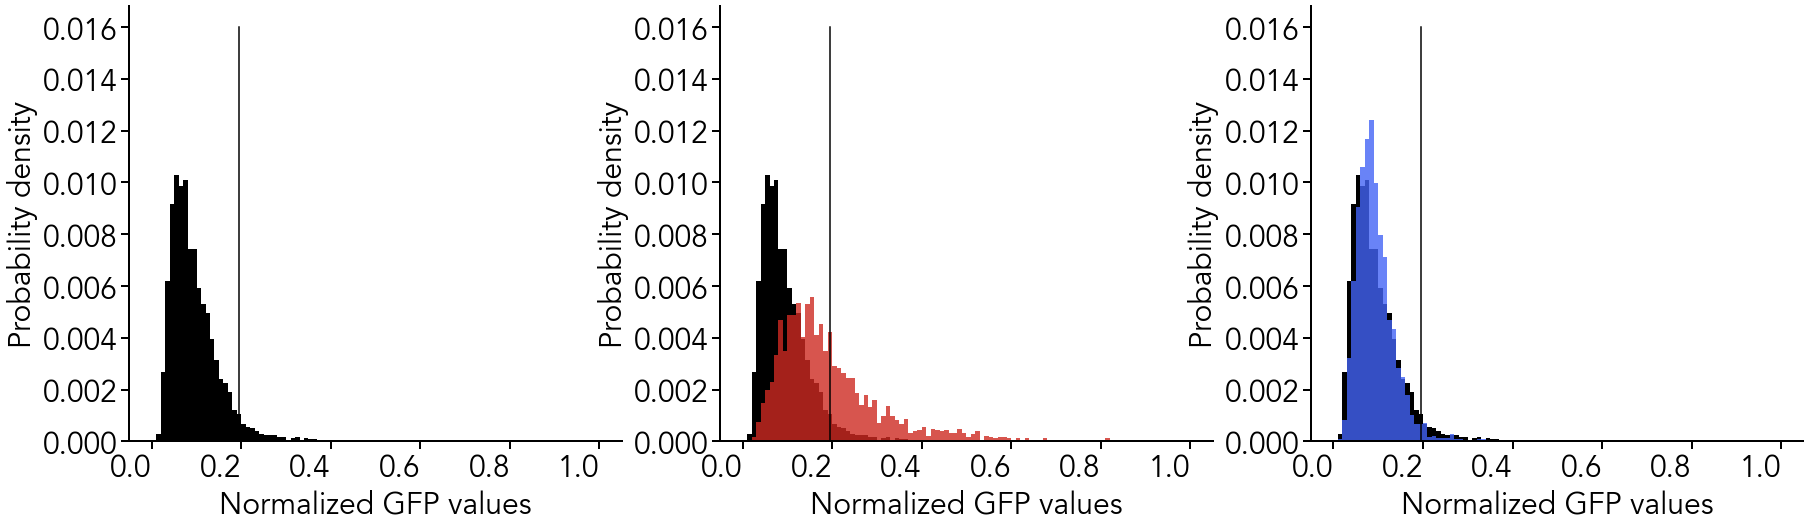

In [5]:
# collect all results

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRtbx2F0s/m2Gt2T/"
dAnalysis = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/m2Gt2T/"

# open file

# uninjected
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
gene = 'wt'
wt_fPaths = ["20201009_5dpf_Rh22G_trb2T_wt_i09b",
          "20201009_5dpf_Rh22G_trb2T_wt_i09d",
          "20201009_5dpf_Rh22G_trb2T_wt_i10b",
          "20201009_5dpf_Rh22G_trb2T_wt_i10d",
          "20201009_5dpf_Rh22G_trb2T_wt_i11b",
          "20201009_5dpf_Rh22G_trb2T_wt_i11d",
          "20201009_5dpf_Rh22G_trb2T_wt_i12b",
          "20201009_5dpf_Rh22G_trb2T_wt_i12d",
          "20210716_5dpf_m2G_t2T_uninj_L101b",
          "20210716_5dpf_m2G_t2T_uninj_L101d",
          "20210716_5dpf_m2G_t2T_uninj_L102b",
          "20210716_5dpf_m2G_t2T_uninj_L103b",
          "20210716_5dpf_m2G_t2T_uninj_L103d",
          "20210716_5dpf_m2G_t2T_uninj_L104b",
          "20210716_5dpf_m2G_t2T_uninj_L104d",
          "20210716_5dpf_m2G_t2T_uninj_L105b",
          "20210716_5dpf_m2G_t2T_uninj_L106b",
          "20210716_5dpf_m2G_t2T_uninj_L106d",
         ]
# tbx2a
gene = 'tbx2a';
tbx2a_fPaths = ["20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b",
#                 "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b",  # is this supposed to be d????
                # #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b", #very curved stack. would require oblique cut
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b", #done; this could be example
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b", #done; very clean L-cone seg
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b",
                #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d", # this in lens up
               ]
# tbx2b
gene = 'tbx2b';
tbx2b_fPaths = ["20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d",
                "20210716_5dpf_m2G_t2T_tbx2b_L102b",
                "20210716_5dpf_m2G_t2T_tbx2b_L102d",
                "20210716_5dpf_m2G_t2T_tbx2b_L104b",
                "20210716_5dpf_m2G_t2T_tbx2b_L104d",
                "20210716_5dpf_m2G_t2T_tbx2b_L105b",
                "20210716_5dpf_m2G_t2T_tbx2b_L105d",
                "20210716_5dpf_m2G_t2T_tbx2b_L106b",
                "20210716_5dpf_m2G_t2T_tbx2b_L107b",
                "20210716_5dpf_m2G_t2T_tbx2b_L108b",
                "20210716_5dpf_m2G_t2T_tbx2b_L108d",
                "20210716_5dpf_m2G_t2T_tbx2b_L109b",
                "20210716_5dpf_m2G_t2T_tbx2b_L110b",
                "20210716_5dpf_m2G_t2T_tbx2b_L111b",
               ]
                
                
rName = 'lGtile'

wtResults = []
i=1;
for fPath in wt_fPaths:
    gene = 'wt'
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
    wtResults.append(results[rName])
    i=i+1;

aResults = []
i=1;
for fPath in tbx2a_fPaths:
    gene = 'tbx2a'
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
    aResults.append(results[rName])
    i=i+1;

bResults = []
i=1;
for fPath in tbx2b_fPaths:
    gene = 'tbx2b'
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
    bResults.append(results[rName])
    i=i+1;


# combine across images
wtResults = np.concatenate(wtResults).ravel()
aResults = np.concatenate(aResults).ravel()
bResults = np.concatenate(bResults).ravel()

# plot histogram
pdfV = True
# wtH, wtB = np.histogram(wtResults, bins = 50, density=pdfV)
# aH, aB = np.histogram(aResults, bins = 50, density=pdfV)
# bH, bB = np.histogram(bResults, bins = 50, density=pdfV)

# plot histogram but first calculate a fixed bin number for all genotypes
# allBins = np.histogram_bin_edges(np.concatenate([wtResults,aResults,bResults]).ravel(),bins='fd');
allBins = np.arange(0,1010,10);
allBinsC = (allBins[:-1] + allBins[1:]) / 2 # Centers
wtH, wtB = np.histogram(wtResults, bins = allBins, density=pdfV)
aH, aB = np.histogram(aResults, bins = allBins, density=pdfV)
bH, bB = np.histogram(bResults, bins = allBins, density=pdfV)

# # this can be used for cumulative distribution then normalized
# wtH = np.cumsum(wtH)/np.max(np.cumsum(wtH));
# aH = np.cumsum(aH)/np.max(np.cumsum(aH));
# bH = np.cumsum(bH)/np.max(np.cumsum(bH));

wt95CI = np.min(allBinsC[(np.cumsum(wtH))>.095])/1000;
wGBright = np.sum(wtH[allBinsC>wt95CI*1000]);
aGBright = np.sum(aH[allBinsC>wt95CI*1000]);
bGBright = np.sum(bH[allBinsC>wt95CI*1000]);

print('GFP threshold is {0}'.format(wt95CI))


baseColor='#000000'
# fH, (axH1,axH2,axH3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
fH, (axH1,axH2,axH3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))
axH1.stairs(wtH,wtB/1000, fill=True, color = baseColor, alpha = 1.0)
axH2.stairs(wtH,wtB/1000, fill=True, color = baseColor, alpha = 1.0)
axH3.stairs(wtH,wtB/1000, fill=True, color = baseColor, alpha = 1.0)
axH2.stairs(aH,aB/1000, fill=True, color = zfC['lws1'], alpha = 0.8)
axH3.stairs(bH,bB/1000, fill=True, color = zfC['sws2'], alpha = 0.8)


axH1.plot([wt95CI,wt95CI],[0,0.016],color=baseColor)
axH2.plot([wt95CI,wt95CI],[0,0.016],color=baseColor)
axH3.plot([wt95CI,wt95CI],[0,0.016],color=baseColor)


# axH.set_title('Distribution of GFP inside L cones')
for axH in (axH1,axH2,axH3):
    formatFigureMain(fH, axH, _)
    axH.set_xlabel('Normalized GFP values')
    if pdfV:
        axH.set_ylabel('Probability density')
    else:
        axH.set_ylabel('Counts')
## normalized
# axH.stairs(wtH/np.max(wtH),wtB, fill=True, color = 'k', alpha = 0.5)
# axH.stairs(aH/np.max(aH),aB, fill=True, color = 'r', alpha = 0.5)
# axH.stairs(bH/np.max(bH),bB, fill=True, color = 'b', alpha = 0.5)

dPath = '/Users/angueyraaristjm/Documents/LiLab/Manuscripts/2021_zfConeRNAseq/resources/'
# dPath = '/Users/angueyraaristjm/Documents/LiLab/Presentations/revealjs/resources/20211008_UCLA/'
# plt.savefig(dPath + "CRtbx2F0_LM_hist.svg", transparent=True, format="svg")

print('# cells of bright GFP cells: wt={0}, tbx2a={1}, tbx2b={2}'.format(wGBright*1000,aGBright*1000,bGBright*1000))

# cells of bright GFP cells: wt=4.502262443438914, tbx2a=35.4997269251775, tbx2b=2.45026686074721


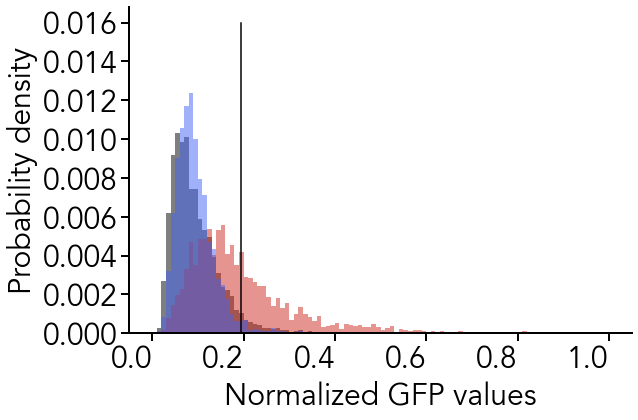

In [9]:

# fH, (axH1,axH2,axH3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
fH, axH = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))


# plot histogram
pdfV = True
# wtH, wtB = np.histogram(wtResults, bins = 50, density=pdfV)
# aH, aB = np.histogram(aResults, bins = 50, density=pdfV)
# bH, bB = np.histogram(bResults, bins = 50, density=pdfV)

# plot histogram but first calculate a fixed bin number for all genotypes
# allBins = np.histogram_bin_edges(np.concatenate([wtResults,aResults,bResults]).ravel(),bins='fd');
allBins = np.arange(0,1010,10);
allBinsC = (allBins[:-1] + allBins[1:]) / 2 # Centers
wtH, wtB = np.histogram(wtResults, bins = allBins, density=pdfV)
aH, aB = np.histogram(aResults, bins = allBins, density=pdfV)
bH, bB = np.histogram(bResults, bins = allBins, density=pdfV)

# # this can be used for cumulative distribution then normalized
# wtH = np.cumsum(wtH)/np.max(np.cumsum(wtH));
# aH = np.cumsum(aH)/np.max(np.cumsum(aH));
# bH = np.cumsum(bH)/np.max(np.cumsum(bH));

wt95CI = np.min(allBinsC[(np.cumsum(wtH))>.095])/1000;
wGBright = np.sum(wtH[allBinsC>wt95CI*1000]);
aGBright = np.sum(aH[allBinsC>wt95CI*1000]);
bGBright = np.sum(bH[allBinsC>wt95CI*1000]);


axH.stairs(wtH,wtB/1000, fill=True, color = 'k', alpha = .5)
axH.stairs(aH,aB/1000, fill=True, color = zfC['lws1'], alpha = .5)
axH.stairs(bH,bB/1000, fill=True, color = zfC['sws2'], alpha = .5)


axH.plot([wt95CI,wt95CI],[0,0.016],color=baseColor)

formatFigureMain(fH, axH, _)
# axH.set_title('Distribution of GFP inside L cones')
axH.set_xlabel('Normalized GFP values')
if pdfV:
    axH.set_ylabel('Probability density')
else:
    axH.set_ylabel('Counts')
## normalized
# axH.stairs(wtH/np.max(wtH),wtB, fill=True, color = 'k', alpha = 0.5)
# axH.stairs(aH/np.max(aH),aB, fill=True, color = 'r', alpha = 0.5)
# axH.stairs(bH/np.max(bH),bB, fill=True, color = 'b', alpha = 0.5)

# dPath = '/Users/angueyraaristjm/Documents/LiLab/Manuscripts/2021_zfConeRNAseq/resources/'
dPath = '/Users/angueyraaristjm/Documents/LiLab/Conferences/2021_RCS/resources/'
# plt.savefig(dPath + "CRtbx2F0_LM_hist.svg", transparent=True, format="svg")

print('# cells of bright GFP cells: wt={0}, tbx2a={1}, tbx2b={2}'.format(wGBright*1000,aGBright*1000,bGBright*1000))

### After establishing threshold based on all data, count number of cells exceeding threshold for each eye

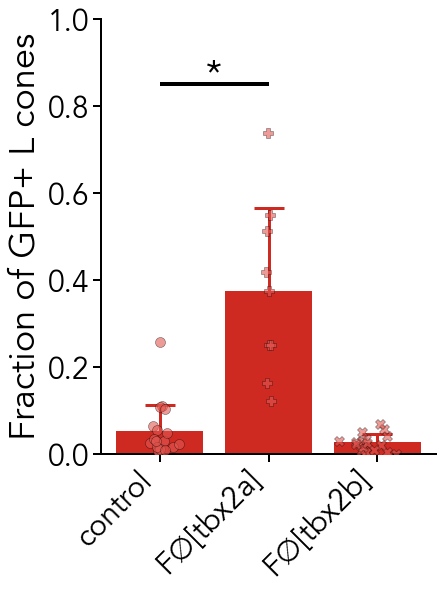

In [11]:
# collect all results

# analysis directory
dAnalysis = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRtbx2F0s/m2Gt2T/"
dAnalysis = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/m2Gt2T/"
# open file

# uninjected
### 20201009: imaged 3dpf and 5dpf larvae. Analyzing 5 dpf for paper
gene = 'wt'
wt_fPaths = ["20201009_5dpf_Rh22G_trb2T_wt_i09b",
          "20201009_5dpf_Rh22G_trb2T_wt_i09d",
          "20201009_5dpf_Rh22G_trb2T_wt_i10b",
          "20201009_5dpf_Rh22G_trb2T_wt_i10d",
          "20201009_5dpf_Rh22G_trb2T_wt_i11b",
          "20201009_5dpf_Rh22G_trb2T_wt_i11d",
          "20201009_5dpf_Rh22G_trb2T_wt_i12b",
          "20201009_5dpf_Rh22G_trb2T_wt_i12d",
          "20210716_5dpf_m2G_t2T_uninj_L101b",
          "20210716_5dpf_m2G_t2T_uninj_L101d",
          "20210716_5dpf_m2G_t2T_uninj_L102b",
          "20210716_5dpf_m2G_t2T_uninj_L103b",
          "20210716_5dpf_m2G_t2T_uninj_L103d",
          "20210716_5dpf_m2G_t2T_uninj_L104b",
          "20210716_5dpf_m2G_t2T_uninj_L104d",
          "20210716_5dpf_m2G_t2T_uninj_L105b",
          "20210716_5dpf_m2G_t2T_uninj_L106b",
          "20210716_5dpf_m2G_t2T_uninj_L106d",
         ]
# tbx2a
gene = 'tbx2a';
tbx2a_fPaths = ["20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b",
#                 "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i07b",  # is this supposed to be d????
                # #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08b", #very curved stack. would require oblique cut
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i08d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09b",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i09d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10b", #done; this could be example
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i10d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11b", #done; very clean L-cone seg
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i11d",
                "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12b",
                #### fPath = "20201009_5dpf_Rh22G_trb2T_CRtbx2a_i12d", # this in lens up
               ]
# tbx2b
gene = 'tbx2b';
tbx2b_fPaths = ["20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07b",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i07d",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08b",
                "20201030_5dpf_Rh22G_trb2T_CRtbx2b_i08d",
                "20210716_5dpf_m2G_t2T_tbx2b_L102b",
                "20210716_5dpf_m2G_t2T_tbx2b_L102d",
                "20210716_5dpf_m2G_t2T_tbx2b_L104b",
                "20210716_5dpf_m2G_t2T_tbx2b_L104d",
                "20210716_5dpf_m2G_t2T_tbx2b_L105b",
                "20210716_5dpf_m2G_t2T_tbx2b_L105d",
                "20210716_5dpf_m2G_t2T_tbx2b_L106b",
                "20210716_5dpf_m2G_t2T_tbx2b_L107b",
                "20210716_5dpf_m2G_t2T_tbx2b_L108b",
                "20210716_5dpf_m2G_t2T_tbx2b_L108d",
                "20210716_5dpf_m2G_t2T_tbx2b_L109b",
                "20210716_5dpf_m2G_t2T_tbx2b_L110b",
                "20210716_5dpf_m2G_t2T_tbx2b_L111b",
               ]
                
rName = 'lGtile'

wtResults = []
i=1;
for fPath in wt_fPaths:
    gene = 'wt'
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
#     wtResults.append(np.count_nonzero(results['lGtile']>wt95CI*1000)) #this is for absolute counts
    wtResults.append(np.divide(np.count_nonzero(results['lGtile']>wt95CI*1000),len(results['lGtile']))) #this is for fraction
    i=i+1;

    
aResults = []
i=1;
for fPath in tbx2a_fPaths:
    gene = 'tbx2a'
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
#     aResults.append(np.count_nonzero(results['lGtile']>wt95CI*1000)) #this is for absolute counts
    aResults.append(np.divide(np.count_nonzero(results['lGtile']>wt95CI*1000),len(results['lGtile']))) #this is for fraction
    i=i+1;

bResults = []
i=1;
for fPath in tbx2b_fPaths:
    gene = 'tbx2b'
    dOut = dAnalysis + gene + '/' + fPath + '/'
    results = np.load(dOut + 'quantificationGFP.npz')
#     bResults.append(np.count_nonzero(results['lGtile']>wt95CI*1000)) #this is for absolute counts
    bResults.append(np.divide(np.count_nonzero(results['lGtile']>wt95CI*1000),len(results['lGtile']))) #this is for fraction
    i=i+1;

geneList = ['wt','tbx2a','tbx2b']


plotname = ''
fH, axH = plt.subplots(figsize= [6,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions


jitter = estimateJitter(wtResults)/400
pH = plt.bar([barStep+1/barD], np.mean(wtResults), width=1/barW, color=zfC['lws1']);
pH = plt.errorbar([barStep+1/barD], np.mean(wtResults), yerr = [[0.025],[np.std(wtResults)]], ecolor=lighten_color(zfC['lws1'],1), elinewidth=3, capsize=15, capthick=3, zorder=7)
pH = plt.scatter(np.ones(len(wtResults))*[barStep+1/barD]+jitter, wtResults, color=lighten_color(zfC['lws1'],.75), zorder=8, marker = zfGm['wt'], s=100, edgecolor='#000000', linewidth=0.5, alpha = .6);
barPos = np.append(barPos,(barStep+1/barD))



jitter = estimateJitter(aResults)/400
pH = plt.bar([barStep+2/barD], np.mean(aResults), width=1/barW, color=zfC['lws1']);
pH = plt.errorbar([barStep+2/barD], np.mean(aResults), yerr = [[0.025],[np.std(aResults)]], ecolor=lighten_color(zfC['lws1'],1), elinewidth=3, capsize=15, capthick=3, zorder=7)
pH = plt.scatter(np.ones(len(aResults))*[barStep+2/barD]+jitter, aResults, color=lighten_color(zfC['lws1'],.75), zorder=8, marker = zfGm['tbx2a'], s=100, edgecolor='#000000', linewidth=0.5, alpha = .6);
barPos = np.append(barPos,(barStep+2/barD))

jitter = estimateJitter(bResults)/400
pH = plt.bar([barStep+3/barD], np.mean(bResults), width=1/barW, color=zfC['lws1']);
pH = plt.errorbar([barStep+3/barD], np.mean(bResults), yerr = [[0.025],[np.std(bResults)]], ecolor=lighten_color(zfC['lws1'],1), elinewidth=3, capsize=15, capthick=3, zorder=7)
pH = plt.scatter(np.ones(len(bResults))*[barStep+3/barD]+jitter, bResults, color=lighten_color(zfC['lws1'],.75), zorder=8, marker = zfGm['tbx2b'], s=100, edgecolor='#000000', linewidth=0.5, alpha = .6);
barPos = np.append(barPos,(barStep+3/barD))

fontProps = formatFigureMain(fH, axH, pH)

# axH.set_ylabel('GFP+ L cones per 64 x 64 $\mu$m$^2$', fontproperties=formatFigureMain(fH, axH, pH))
# axH.set_ylim([0,180]);
# stath = 170

axH.set_ylabel('Fraction of GFP+ L cones', fontproperties=fontProps)
axH.set_ylim([0,1]);
stath = 0.85

geneList = ['control','F$\emptyset$[tbx2a]','F$\emptyset$[tbx2b]']

axH.xaxis.set_tick_params(rotation=45)
axH.set_xticks(np.sort(barPos));
axH.set_xticklabels(geneList);

hH = plt.hlines(stath, barPos[0], barPos[1], colors='#000000',linewidth=4)
plt.text((barPos[0]+barPos[1])/2, stath, '*', font_properties=fontProps, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")


dPath = '/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/Manuscripts/2021_zfConeRNAseq/resources/'
# dPath = '/Users/angueyraaristjm/Documents/LiLab/Presentations/revealjs/resources/20211008_UCLA/'
# plt.savefig(dPath + "CRtbx2F0_GFPLcones.svg", transparent=True, format="svg")

print('Threshold (5%) is {0}'.format(wt95CI))

## Stats

### Kruskal-Wallis

In [17]:
geneList = ['wt','tbx2a','tbx2b']
print('wt fractions:')
print('\tmean = {0:.3f}%, s.d. = {1:.5f}%'.format(np.mean(wtResults)*100,np.std(wtResults)*100))
print('tbx2a fractions:')
print('\tmean = {0:.3f}%, s.d. = {1:.5f}%'.format(np.mean(aResults)*100,np.std(aResults)*100))
print('tbx2b fractions:')
print('\tmean = {0:.3f}%, s.d. = {1:.5f}%'.format(np.mean(bResults)*100,np.std(bResults)*100))
# Kruskal-Wallis test for repeated testing
H, p = kruskal(wtResults, aResults,bResults)
print('H = {0:.3f}, p = {1:.20f}, nEyes: wt = {2:.0f}; {3} = {4:.0f}; {5} = {6:.0f}'.format(H,p,len(wtResults),geneList[1],len(aResults),geneList[2],len(bResults)))
if p<0.01:
    r = scikit_posthocs.posthoc_conover([wtResults, aResults, bResults], p_adjust='Bonferroni')
    # r = scikit_posthocs.posthoc_conover([wtCount, aCount, bCount])
    print('\tConover-Iman posthoc + Bonferroni p adjustment:')
    print('\t\twt vs. {0}: p = {1:.20f} | p = {1}'.format(geneList[1],r.iloc[0,1]))
    print('\t\twt vs. {0}: p = {1:.20f} | p = {1}'.format(geneList[2],r.iloc[0,2]))
    print('\t\t{0} vs. {1}: p = {2:.20f} | p = {2}'.format(geneList[1],geneList[2],r.iloc[1,2]))
    
    r = scikit_posthocs.posthoc_dunn([wtResults, aResults, bResults], p_adjust='Bonferroni')
    # r = scikit_posthocs.posthoc_conover([wtCount, aCount, bCount])
    print('\tDunn posthoc + Bonferroni p adjustment:')
    print('\t\twt vs. {0}: p = {1:.20f} | p = {1}'.format(geneList[1],r.iloc[0,1]))
    print('\t\twt vs. {0}: p = {1:.20f} | p = {1}'.format(geneList[2],r.iloc[0,2]))
    print('\t\t{0} vs. {1}: p = {2:.20f} | p = {2}\n'.format(geneList[1],geneList[2],r.iloc[1,2]))
    

wt fractions:
	mean = 5.197%, s.d. = 6.00884%
tbx2a fractions:
	mean = 37.481%, s.d. = 18.93228%
tbx2b fractions:
	mean = 2.578%, s.d. = 1.87454%
H = 20.821, p = 0.00003012039221262711, nEyes: wt = 18; tbx2a = 9; tbx2b = 17
	Conover-Iman posthoc + Bonferroni p adjustment:
		wt vs. tbx2a: p = 0.00002874610768070364 | p = 2.874610768070364e-05
		wt vs. tbx2b: p = 0.63496081853536545658 | p = 0.6349608185353655
		tbx2a vs. tbx2b: p = 0.00000113450280688830 | p = 1.134502806888295e-06
	Dunn posthoc + Bonferroni p adjustment:
		wt vs. tbx2a: p = 0.00061331306319525154 | p = 0.0006133130631952515
		wt vs. tbx2b: p = 1.00000000000000000000 | p = 1.0
		tbx2a vs. tbx2b: p = 0.00002658597194288433 | p = 2.6585971942884327e-05



### Mann_Whitney

In [ ]:
print('wt fractions:')
print('\tmean = {0:.3f}%, s.d. = {1:.5f}%'.format(np.mean(wtResults)*100,np.std(wtResults)*100))
print('tbx2a fractions:')
print('\tmean = {0:.3f}%, s.d. = {1:.5f}%'.format(np.mean(aResults)*100,np.std(aResults)*100))
print('tbx2b fractions:')
print('\tmean = {0:.3f}%, s.d. = {1:.5f}%'.format(np.mean(bResults)*100,np.std(bResults)*100))
# Mann Whitney 
Au, pA = mannwhitneyu(wtResults, aResults)
print('wt vs. tbx2a:')
print('\tU = {0:.3f}, p = {1:.5f}'.format(Au,pA))
Bu, pB = mannwhitneyu(wtResults, bResults)
print('wt vs. tbx2b:')
print('\tU = {0:.3f}, p = {1:.5f}'.format(Bu,pB))

In [ ]:
# divide images into 1000 bins
mH, mB = np.histogram(viewer.layers['M_mip'].data.flatten(), bins = 1000)
lH, lB = np.histogram(viewer.layers['L_mip'].data.flatten(), bins = 1000)


fH, axH = plt.subplots(figsize=(8,8))
axH.stairs(lH,lB, fill=True, color = 'm', alpha = 0.5)
axH.stairs(mH,mB, fill=True, color = 'g', alpha = 0.5)

In [ ]:
viewer.close()

In [ ]:
viewer

```python
# change keybind for default actions:
@viewer.bind_key('F1', overwrite=True)
def eraserMode(viewer):
    viewer.layers.selection.active.mode = 'fill'
    viewer.layers.selection.active.mode = 'paint'
    viewer.layers.selection.active.mode = 'erase'
    viewer.layers.selection.active.mode = 'pick'
    viewer.layers.selection.active.mode = 'pan_zoom'

# napari native functions for other actions

@register_label_action(
    trans._(
        "Set the currently selected label to the largest used label plus one."
    ),
)
def new_label(layer):
    """Set the currently selected label to the largest used label plus one."""
    layer.selected_label = layer.data.max() + 1


@register_label_action(
    trans._("Decrease the currently selected label by one."),
)
def decrease_label_id(layer):
    layer.selected_label -= 1


@register_label_action(
    trans._("Increase the currently selected label by one."),
)
def increase_label_id(layer):
    layer.selected_label += 1

```